### Imports

In [1]:
import sys
import json
import matplotlib.pyplot as plt
from pprint import pprint
import numpy as np

### Local imports

In [2]:
sys.path.insert(0,'src/')
from src.metrics import BinaryClassificationResult
from src.print_util import print_rates

## Part 1: generic code

In [3]:
def get_value(result: BinaryClassificationResult):
    return result.acc()

In [4]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results(all_results):
    total_results = BinaryClassificationResult()
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_results in enumerate(configuration_results):
            if isinstance(run_results, list):  # This means that the experiment was federated
                # In that case we just look at the last results
                total_results += BinaryClassificationResult(*run_results[-1].values())
            else:
                total_results += BinaryClassificationResult(*run_results.values())
            
    return total_results

## Part 2: grid search results

In [5]:
# Get the results of a single configuration, for a single experiment, summed over the reruns
# out of the results for every device in the right order
def get_combined_results(all_devices_experiment_results, clients_devices):
    results = BinaryClassificationResult()
    for run, run_results in enumerate(all_devices_experiment_results):
        # We need a configuration that tested all devices in order to be able to reconstruct the results
        assert(len(run_results) == 9)
        for device_id, device_results in enumerate(run_results):
            if [device_id] in clients_devices:
                results += BinaryClassificationResult(*device_results.values())
                
    return results

In [6]:
path_gs = 'grid_search_results/centralized_autoencoder/run_0/'

In [7]:
with open(path_gs + 'local_results.json') as json_file:
    gs_local_results = json.load(json_file)

### Single autoencoder

In [50]:
def get_configurations_best_hparams(all_results, verbose=False):
    config_to_hparams = {}
    for clients_devices, config_results in gs_local_results.items():
        config_best_result = np.Infinity
        config_best_hparams = {}
        for hparams, config_exp_result in config_results.items():
            if config_exp_result < config_best_result:
                config_best_hparams = hparams
                config_best_result = config_exp_result
        config_to_hparams.update({clients_devices: config_best_hparams})
        if verbose:
            print("Best result for {} is {:.5f} with hparams: ".format(clients_devices, config_best_result))
            pprint(config_best_hparams)
            print()
            
    return config_to_hparams

In [58]:
clients_devices_to_hparams = get_configurations_best_hparams(gs_local_results)
clients_devices_to_hparams

{'[[1, 2, 3, 4, 5, 6, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 2, 3, 4, 5, 6, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 3, 4, 5, 6, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 2, 4, 5, 6, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 2, 3, 5, 6, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 2, 3, 4, 6, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 2, 3, 4, 5, 7, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 2, 3, 4, 5, 6, 8]]': "{'normalization': 'min-max', 'hidden_layers': [29]}",
 '[[0, 1, 2, 3, 4, 5, 6, 7]]': "{'normalization': 'min-max', 'hidden_layers': [29]}"}

### Single classifier

In [9]:
for clients_devices, config_results in gs_local_results.items():
    print(clients_devices)
    for hparams, config_exp_results in config_results.items():
        print(hparams)
        result = BinaryClassificationResult(*config_exp_results.values())
        print_rates(result)
        print(get_value(result))
        
    print()

[[1, 2, 3, 4, 5, 6, 7, 8]]
{'normalization': '0-mean 1-var', 'hidden_layers': [11]}


AttributeError: 'float' object has no attribute 'values'

## Part 3: test results analysis

### Non-federated

In [15]:
# Get the results of a single experiment, summed over the reruns and the configurations
def get_results_non_federated(all_results):
    for configuration, configuration_results in all_results.items():      
        result = BinaryClassificationResult()
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_result in enumerate(configuration_results):
            result += BinaryClassificationResult(*run_result.values())
                
    return result

In [21]:
path_test = 'test_results/centralized_autoencoder/run_0/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)

In [22]:
local_result = get_results_non_federated(test_local_results)
new_result = get_results_non_federated(test_new_results)
print("Local result: ")
print_rates(local_result)
print()

print("New result: ")
print_rates(new_result)

Local result: 
TPR: 0.99986 - TNR: 0.95519 - Accuracy: 0.99903 - Recall: 0.99986 - Precision: 0.99915 - F1-Score: 0.99951

New result: 
TPR: 0.99988 - TNR: 0.97168 - Accuracy: 0.99923 - Recall: 0.99988 - Precision: 0.99934 - F1-Score: 0.99961


### Federated

In [10]:
# Get the results for each federation round of a single experiment, summed over the reruns and the configurations
def get_results_per_round(all_results):
    results_per_round = []
    for configuration, configuration_results in all_results.items():      
        # Run can be a random rerun (when testing) or a fold (when grid searching)
        for run, run_results in enumerate(configuration_results):
            for federation_round, round_results in enumerate(run_results):
                if federation_round >= len(results_per_round):
                    results_per_round.append(BinaryClassificationResult())  
                results_per_round[federation_round] += BinaryClassificationResult(*round_results.values())
                
    return results_per_round

In [11]:
def plot_federated_tpr_tnr(results_to_plot, title=''):
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.set_xlabel('Federation round')

    color = 'blue'
    ax1.set_title(title)
    ax1.set_ylabel('TPR', color=color)
    ax1.plot([result.tpr() for result in results_to_plot], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.ticklabel_format(useOffset=False)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'red'
    ax2.set_ylabel('TNR', color=color)
    ax2.plot([result.tnr() for result in results_to_plot], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

In [12]:
def plot_federated_acc(results_to_plot, title=''):
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.set_xlabel('Federation round')

    color = 'green'
    ax.set_title(title)
    ax.set_ylabel('Accuracy', color=color)
    ax.plot([result.acc() for result in results_to_plot], color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.ticklabel_format(useOffset=False)
    plt.show()

In [13]:
path_test = 'test_results/decentralized_classifier_federated/run_0/'

with open(path_test + 'local_results.json') as json_file:
    test_local_results = json.load(json_file)
    
with open(path_test + 'new_devices_results.json') as json_file:
    test_new_results = json.load(json_file)

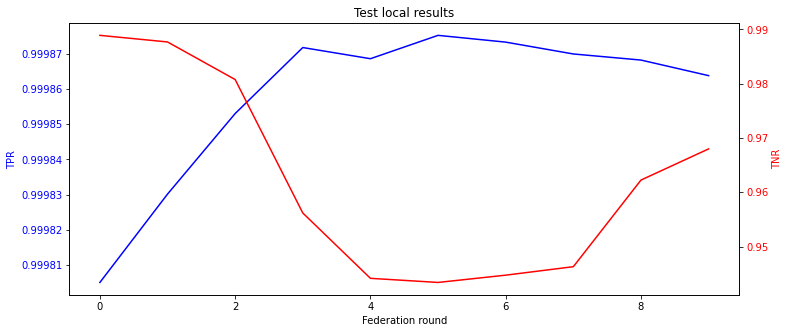

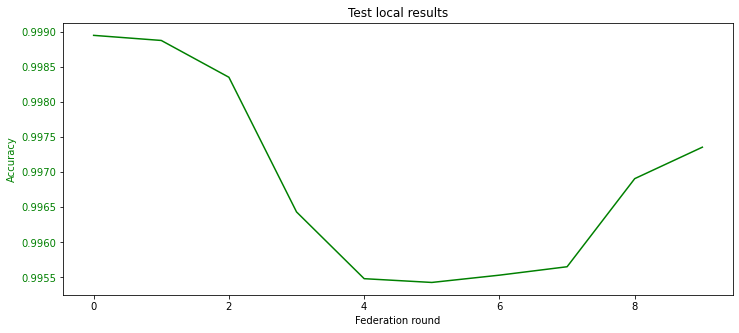

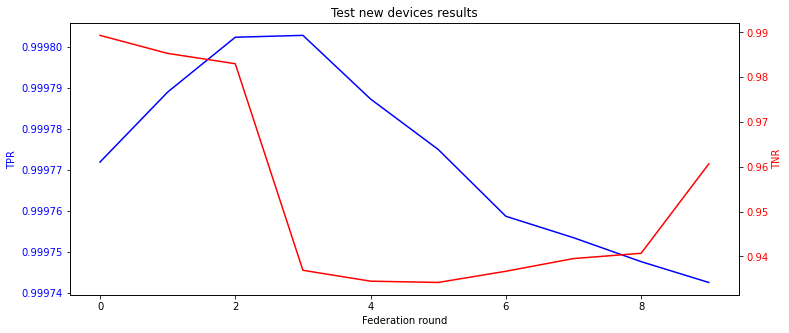

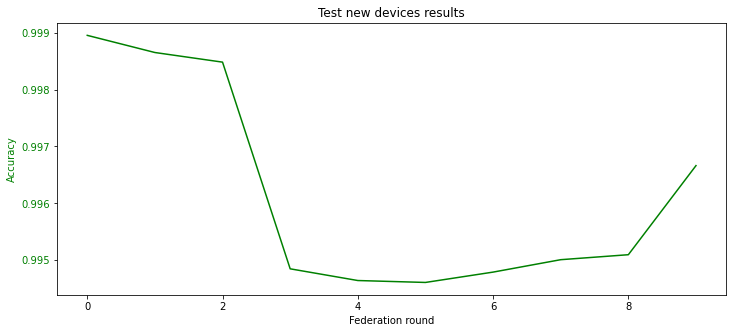

In [14]:
local_results_per_round = get_results_per_round(test_local_results)
plot_federated_tpr_tnr(local_results_per_round, title='Test local results')
plot_federated_acc(local_results_per_round, title='Test local results')

new_results_per_round = get_results_per_round(test_new_results)
plot_federated_tpr_tnr(new_results_per_round, title='Test new devices results')
plot_federated_acc(new_results_per_round, title='Test new devices results')

These plots are interesting but could be improved with confidence intervals.